In [66]:
import pandas
from yahoo_fin.stock_info import get_data
import google.cloud
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt


In [29]:
# Get historical FTSE data that can be used for training and testing
ftse_historical = get_data("^ftse", start_date="12/04/2009", end_date="12/04/2019", index_as_date = False, interval="1d")

In [30]:
# Calculate the daily change in price which will be our dependent variable for analysis
ftse_historical["change"] = ftse_historical["close"] - ftse_historical["open"]

In [31]:
# Load GDELT data from BigQuery

In [32]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [33]:
%%bigquery gdelt_events_daily_summary
SELECT
    PARSE_DATE("%Y%m%d",CAST(SQLDATE as string)) as EventDate
    --, Actor1KnownGroupCode
    --, Actor1EthnicCode
    --, Actor1Religion1Code
    --, Actor1Type1Code
    --, Actor2KnownGroupCode
    --, Actor2EthnicCode
    --, Actor2Religion1Code
    --, Actor2Type1Code
    --, NumMentions
    --, NumSources
    , avg(AvgTone) as AvgTone
    , STDDEV(AvgTone) as StdDevTone
    , avg(GoldsteinScale) as AvgGoldstein
    , STDDEV(GoldsteinScale) as StdDevGoldstein
FROM 
    `gdelt-bq.gdeltv2.events` 
where 
    PARSE_DATE("%Y%m%d",CAST(SQLDATE as string)) > DATE "2010-01-01"
AND
    (Actor1CountryCode = 'GBR'
    or 
    Actor2CountryCode = 'GBR')
GROUP BY
    1
    

In [34]:
# As we are using todays events to predict tomorrow's change in prices, we must add a day to the event date so that we can join to the FTSE table
gdelt_events_daily_summary["date_t1"] = gdelt_events_daily_summary["EventDate"] + timedelta(days=1)

In [35]:
# Dates from bigquery must be converted to proper datetime data types so they can be joined to the FTSE table
gdelt_events_daily_summary["EventDate"] = gdelt_events_daily_summary["EventDate"].astype("datetime64[ns]")
gdelt_events_daily_summary["date_t1"] = gdelt_events_daily_summary["date_t1"].astype("datetime64[ns]")

In [36]:
# Join GDELT and FTSE data
gdelt_ftse = ftse_historical.merge(right = gdelt_events_daily_summary, how = 'inner', left_on = "date", right_on = "date_t1")
gdelt_ftse.dropna(inplace = True)

In [37]:
# Dependent Variable
Y = gdelt_ftse["change"]

In [60]:
# Independent Variables
X = gdelt_ftse[["AvgTone", "StdDevTone", "AvgGoldstein", "StdDevGoldstein"]]
# Add a constant
# X["constant"] = 1

In [61]:
# Split training and testing data
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.4, random_state=0)

In [62]:
# Run linear regression model
regr = LinearRegression()
regr.fit(X_train,Y_train, )

LinearRegression()

In [49]:
# Test model against test data
Y_pred = regr.predict(X_test)

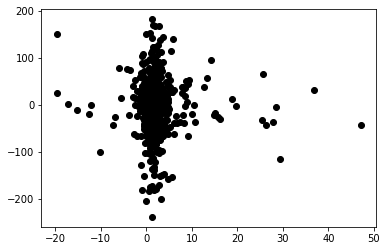

In [50]:
# Review model predictions against reality
plt.scatter(Y_pred, Y_test,  color='black')

In [59]:
# The coefficients
print('Coefficients: \n', list(zip(X.columns, regr.coef_)))

Coefficients: 
 [('AvgTone', 2.4061805251429216), ('StdDevTone', -4.936266920768984), ('AvgGoldstein', -4.339189763539138), ('StdDevGoldstein', 2.0281175694677342), ('constant', 0.0)]


In [52]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, Y_pred))

Mean squared error: 3630.70


In [63]:
# R-Squared
print('Coefficient of determination: %.2f'
      % r2_score(Y_test, Y_pred))

Coefficient of determination: -0.02


In [67]:
# Save Model
joblib.dump(regr, "gdelt_ftse_regression.pkl")

['gdelt_ftse_regression.pkl']